# Unsupervised Classification
A script that uses unsupervised classification to explore the data a little bit and see if we can reconstruct the labels directly without using supervised learning. 

In [1]:
import common, preprocess, numpy as np
import pandas as pd

In [2]:
zImages = preprocess.getKeyFeatures()


100%|██████████| 10/10 [01:43<00:00, 10.32s/it]


We're going to first try using just the features that we previously selected. 

In [3]:
df = pd.DataFrame()
for k, keepKey in enumerate(zImages):
    band = zImages[keepKey]
    df[keepKey] = band.flatten()
    

In [4]:
subset = df.sample(n=100000)

While we could run the clustering algorithms directly on the entire images, in practice that takes too much compute time, and typically gains you very little unless you want to overfit your data, so random downsampling is typically a good idea.  

In [5]:
labelImage = common.loadNumpy('labels')

In [6]:
h,w= labelImage.shape

First up is the classic KMeans clustering algorithm. KMeans works well when there is large separation between clusters. I would expect it to not do so well here because of the significant amount of similarity between clusters just looking at the band images visually. Another big problem with K-means is the need to select the number of classes that you want.  In this case, we're just going to select 7 because I did some testing and saw that it was really making very small clusters when we increased it beyond this.

In [7]:
from sklearn.cluster import KMeans

In [8]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(subset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
classes = kmeans.predict(df)

In [10]:
kclass = classes.reshape(h,w)

We're going to compare the K-means clustering results with the desired classes directly in image format.  Note: the colorbars are not directly comparable because the class numbers don't correspond to one another yet, but in general we can see some similar patterns.  Here are some correspondences that I think stand out based on the colors in each image:

| K-means | Labeled Image |
|---------|---------------|
| purple  |  orange       |
|pink     | green        |
|orange   | red           |
|green      | brown         |


In [11]:
from pylab import *
figure(figsize=(20,20))
subplot(211)
title('K-means')
imshow(kclass,cmap='tab10',vmax=10)
colorbar()
subplot(212)
title('Labeled')
imshow(labelImage,cmap='tab10',vmax=10)
colorbar()

In [12]:
from scipy.stats import mode
classMapping = {}
for k in range(10):
    mask = kclass == k
    most_likely, _ =  mode(labelImage[mask])
    if len(most_likely) > 0:
        classMapping[k] = most_likely[0]
        print('most likely class: ', k,most_likely)

most likely class:  0 [5]
most likely class:  1 [2]
most likely class:  2 [1]
most likely class:  3 [1]
most likely class:  4 [3]
most likely class:  5 [1]
most likely class:  6 [0]


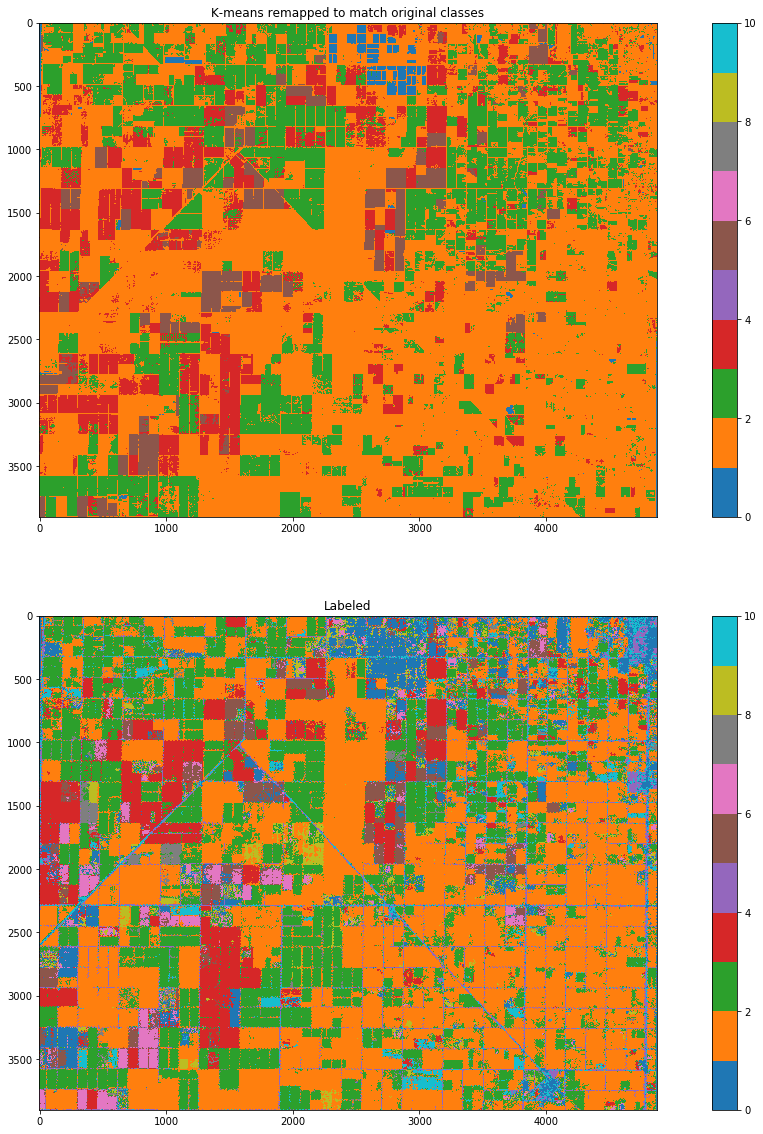

In [13]:
figure(figsize=(20,20))
subplot(211)
title('K-means remapped to match original classes')
kremap = np.zeros_like(kclass)
for kc, mc in classMapping.items():
    kremap[kclass == kc] = mc
# kremap[kclass == 4] = 1 # purple -> orange
# kremap[kclass == 6] = 2 # pink -> green
# kremap[kclass == 1] = 3 # orange -> red
# kremap[kclass == 2] = 5 # green -> brown
imshow(kremap,cmap='tab10', vmax=10)
colorbar()
subplot(212)
title('Labeled')
imshow(labelImage,cmap='tab10',vmax=10)
colorbar()

Another way to visualize the data is to remap the classes from Kmeans to the classes in the labeled dataset. I estimated which class each Kmeans cluster belongs to by simply looking at the most likely occuring class at the corresponding points in the label image.  As the image above shows, there is actually pretty decent correspondence betwen the Kmeans clusters and some of the classes, but it's not a perfect match.

We could try other clustering algorithms to see if we can get better results, but ultimately I think it's not really worth the effort to see something marginally better when we're going to do supervised classification anyways...